In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline 
from networks import *
import math
import torch.distributions as dist

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)
np.random.seed(0)

## Propagating Uncertainty Through a Differential Equation
Consider the steady state heat equation on a heterogeneous rod with no heat sources:
$$
\frac{d}{dx}\left(a(x)\frac{d}{dx}u(x)\right) = 0,
$$
and boundary values:
$$
u(0) = 1\;\mbox{and}\;u(1) = 0.
$$
We are interested in cases in which we are uncertain about the conductivity, $a(x)$.
Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $a(x)$ that represents our uncertainty.
This requires assigning a probability measure on a function space.
For now, we will just give you a model.
We will model $a = a(x;\boldsymbol{\xi})$ as:
$$
a(x;\boldsymbol{\xi}) = \exp\{g(x;\boldsymbol{\xi})\},
$$
where  $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $a(x;\boldsymbol{\xi})$ must be positive.
We will assume that the random field ia a [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
This is a field that it is no-where continuous and it is actually a fractal (when you zoom in the spatial dimension, the field resembles itself at a larger scale).
The Karhunen-Loeve expansion of the field is:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are the eigenfunctions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.

Let's implement the field:

In [2]:
# This computes the random field given a xi
def g(x, xi, sigma=1.):
    """
    Arguments:
    x     -   Column containing the points at which you wish to evaluate the field.
    xi    -   Array of the random variables. The number of columns correspond to 
              corresponds to the ``d`` in the math above.
    sigma -   This is the variance of the field.
    """
    res = torch.zeros((xi.shape[0], 1))
    d = xi.shape[1]
    for i in range(1, d+1):
        res += xi[:, i-1].reshape(-1,1) * math.sqrt(2) * sigma * torch.sin((i - .5) * math.pi * x) / ((i - .5) * math.pi)
    return res

In [3]:
B1 = 1 # boundary_value_left
B2 = 0 # boundary_value_right
u_trail = lambda x, inputs, net: (B1*(1-x))+(B2*x)+(x*(1-x)*net(inputs))

sigma = 1.5

def sqresidual(net, x, xi):
    assert x.requires_grad == True
    inputs = torch.hstack([x, xi])
    u = u_trail(x, inputs, net)
    a_val = torch.exp(g(x, xi, sigma = sigma))
    ux = torch.autograd.grad(u, x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(u))[0]
    term = torch.autograd.grad(a_val * ux, x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(ux))[0]
    f = 0
    residual = (-term - f)**2
    return torch.mean(residual)

def energyfunctional(net, x, xi):
    assert x.requires_grad == True 
    inputs = torch.hstack([x, xi])
    u = u_trail(x, inputs, net)
    a_val = torch.exp(g(x, xi, sigma = sigma))
    ux = torch.autograd.grad(u, x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(u))[0]
    f = 0
    functional = 0.5*a_val*ux**2 - f*u
    return torch.mean(functional)

In [4]:
d_xi = 5 #  number of terms to consider

xi_dist = dist.Normal(loc=torch.zeros(d_xi), scale=torch.ones(d_xi))

In [5]:
## define a network to approximate the PDE solution 
# layersizes = [1+ d_xi] + [40]*10 + [1]  
# pinn = DenseNet(layersizes=layersizes, activation=nn.SiLU())
pinn = DenseResNet(dim_in=1+(d_xi), dim_out=1, num_resnet_blocks=5, 
                 num_layers_per_block=3, num_neurons=40, activation=nn.SiLU())

loss_func = energyfunctional

### define an optimizer 
lr = 1e-3
update = torch.optim.Adam(params=pinn.parameters(), lr=lr)

# training loop params 
maxiter = 50000
batchsize = 500
best_stat_dict = pinn.state_dict()
best_val_loss = np.inf
x_val = torch.rand((2000,1), requires_grad=True)
xi_val = xi_dist.sample([2000]) 

## training loop 
for i in range(maxiter):
    # sample a batch of data 
    x_batch = torch.rand((batchsize,1), requires_grad=True)
    xi_batch = xi_dist.sample([batchsize]) 
    
    # zero out the gradient buffers
    update.zero_grad()
    
    # compute the regularized loss 
    loss = loss_func(pinn, x_batch, xi_batch) 
    
    # back prop to get gradients 
    loss.backward()
    
    # take one optimization step
    update.step()
    
    # print progress 
    if (i+1)%1000 == 0:
        val_loss = loss_func(pinn, x_val, xi_val)
        print(' [Iteration %4d] Training loss: %.5f, Validation loss: %.5f'%(i+1, loss, val_loss))
        if val_loss < best_val_loss:
            best_state_dict = pinn.state_dict()
pinn.load_state_dict(best_stat_dict);

 [Iteration 1000] Training loss: 0.66187, Validation loss: 0.61991
 [Iteration 2000] Training loss: 0.67383, Validation loss: 0.61189
 [Iteration 3000] Training loss: 0.52907, Validation loss: 0.59752
 [Iteration 4000] Training loss: 0.53339, Validation loss: 0.59627
 [Iteration 5000] Training loss: 0.57218, Validation loss: 0.60228
 [Iteration 6000] Training loss: 0.60123, Validation loss: 0.59436
 [Iteration 7000] Training loss: 0.58813, Validation loss: 0.58408
 [Iteration 8000] Training loss: 0.57929, Validation loss: 0.59410
 [Iteration 9000] Training loss: 0.54727, Validation loss: 0.59046
 [Iteration 10000] Training loss: 0.64201, Validation loss: 0.59719
 [Iteration 11000] Training loss: 0.61188, Validation loss: 0.58908
 [Iteration 12000] Training loss: 0.57217, Validation loss: 0.58548
 [Iteration 13000] Training loss: 0.65678, Validation loss: 0.59418
 [Iteration 14000] Training loss: 0.57156, Validation loss: 0.58994
 [Iteration 15000] Training loss: 0.53818, Validation los

In [6]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    g           -    The random field the describes the conductivity.
    nx          -    Number of grid points.
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, g=g, nx=100, value_left=1., value_right=0.):
        self.g = g
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.A = fipy.FaceVariable(name='$A(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.A)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        g_val = self.g(torch.from_numpy(x).reshape(-1,1), xi.repeat(len(x),1), sigma = sigma).flatten()
        self.A.setValue( torch.exp(g_val).data.numpy() )
        self.eq.solve(var=self.phi)
        return x, self.phi.faceValue()


In [7]:
torch.save(best_state_dict, 'model_state_dict_pinn.pt')

Validation loss: 0.60475


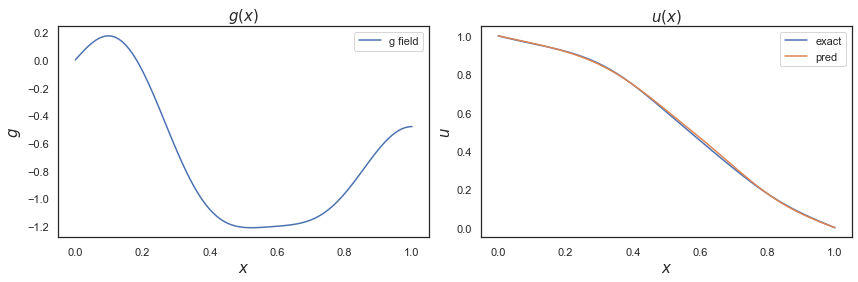

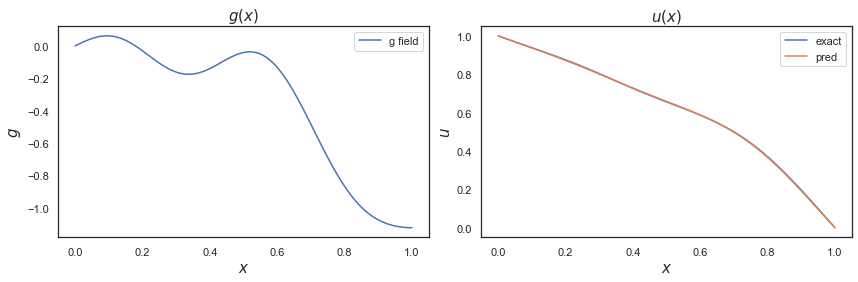

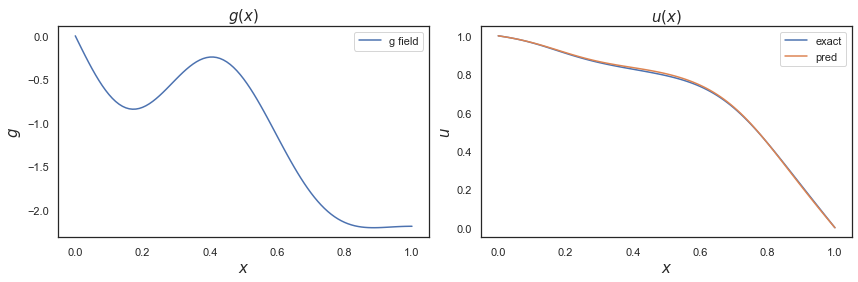

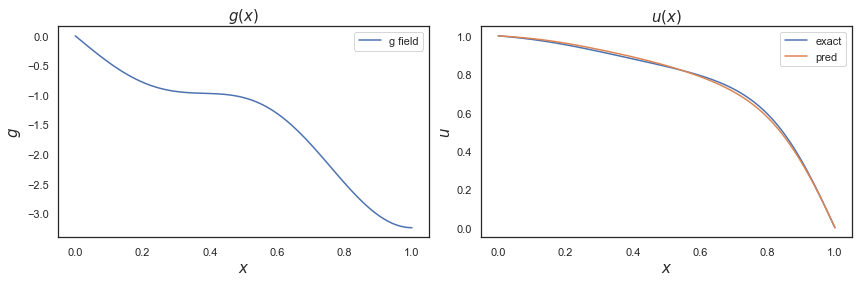

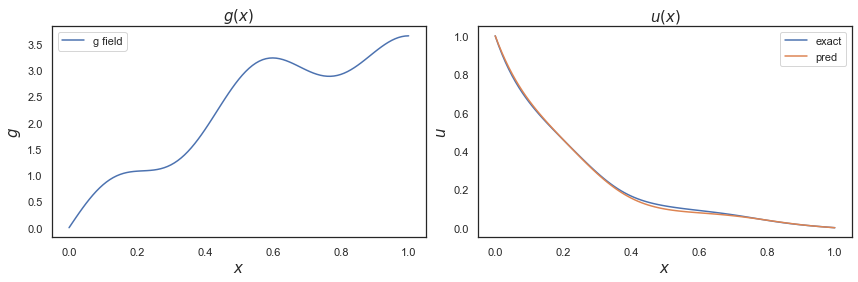

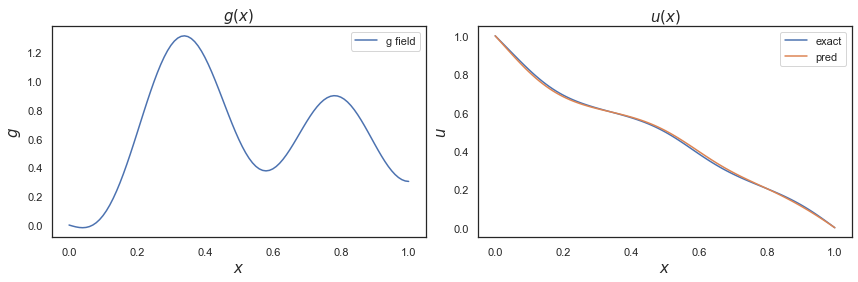

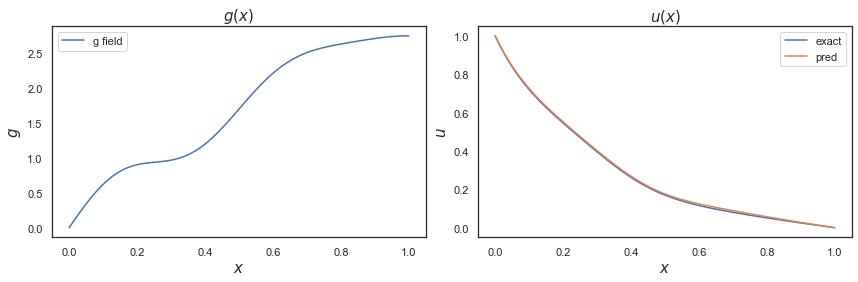

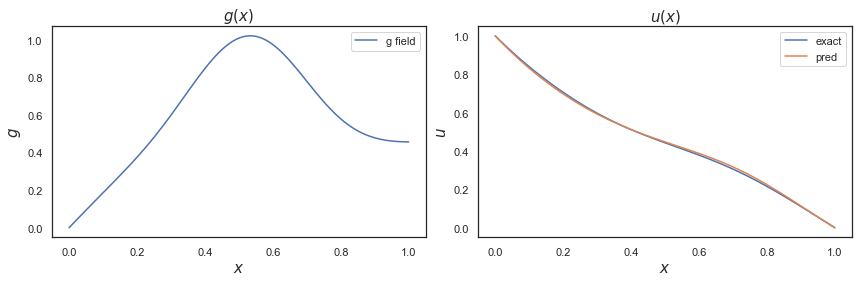

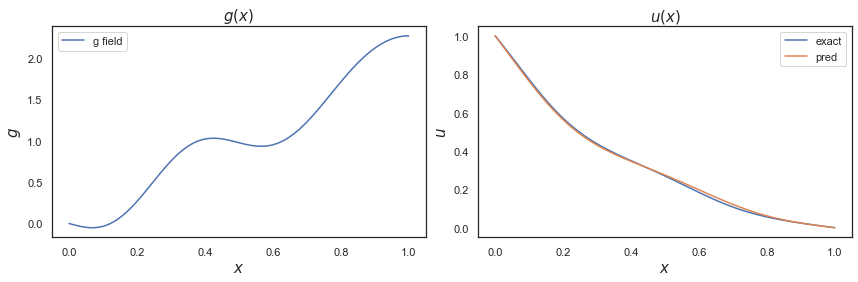

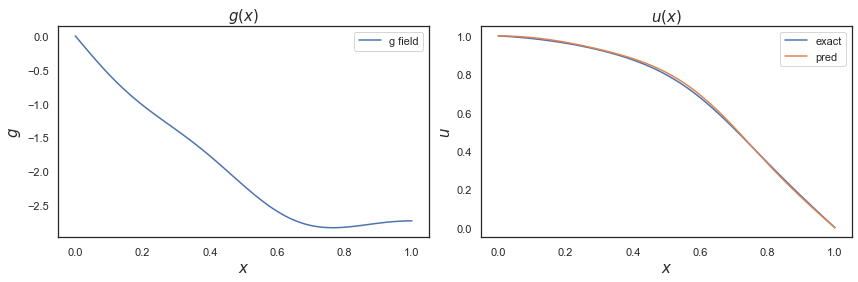

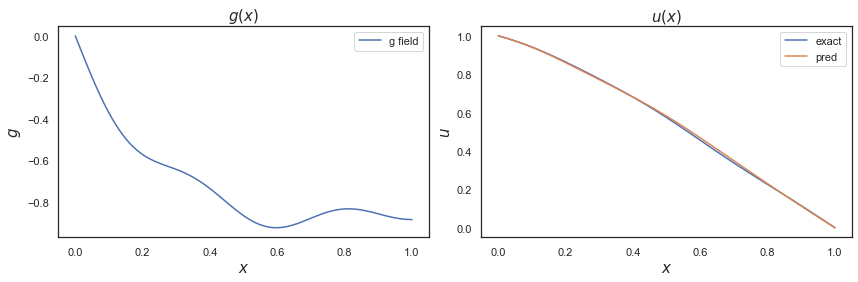

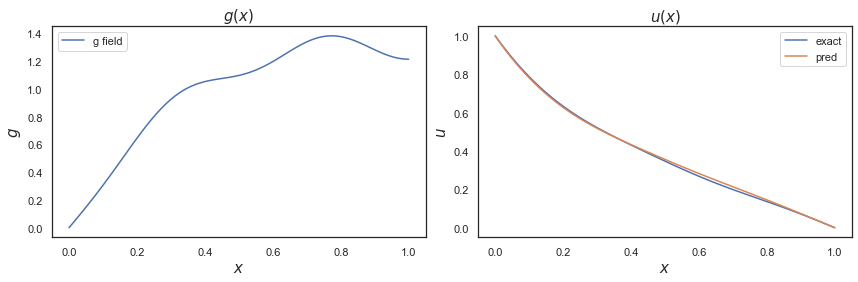

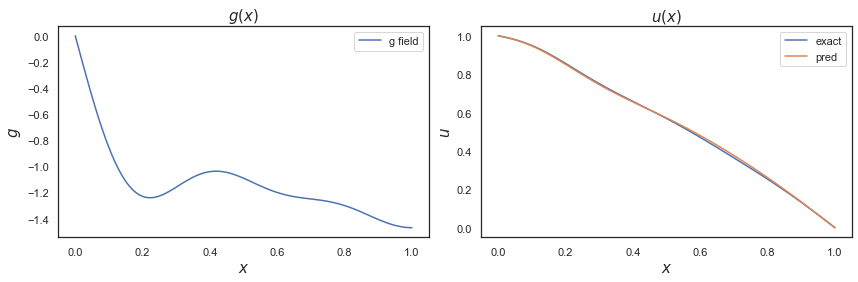

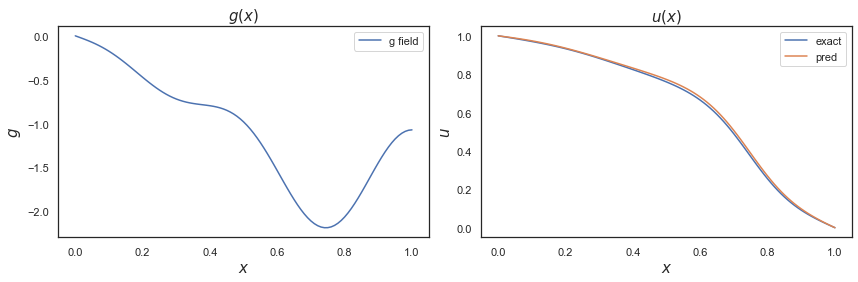

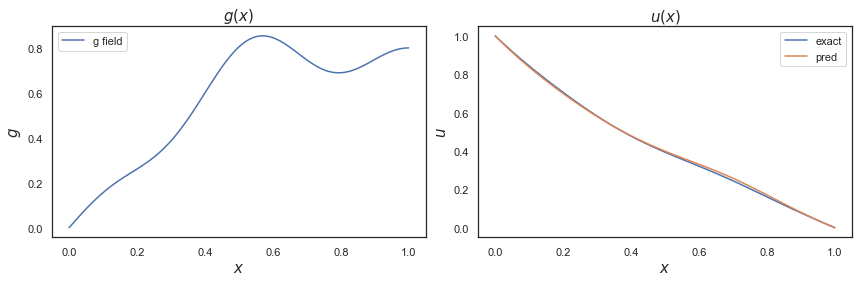

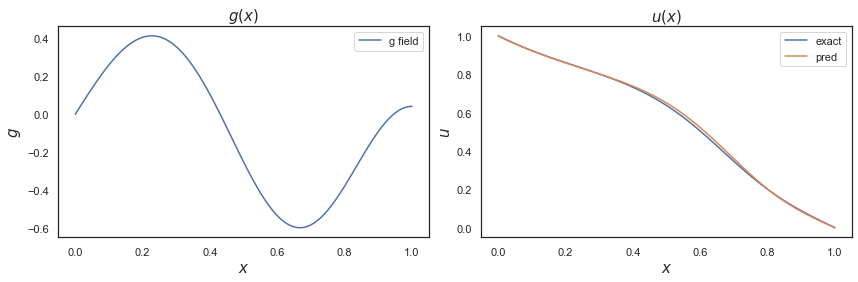

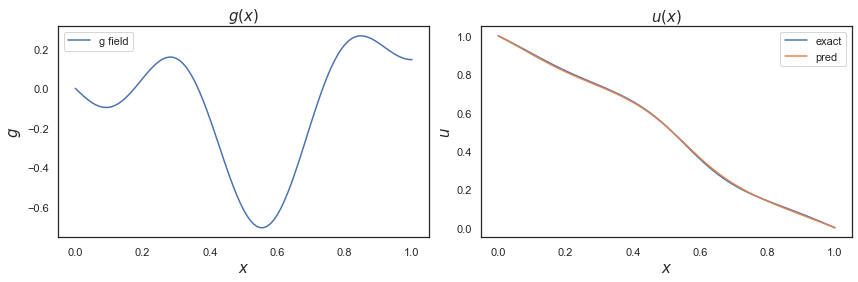

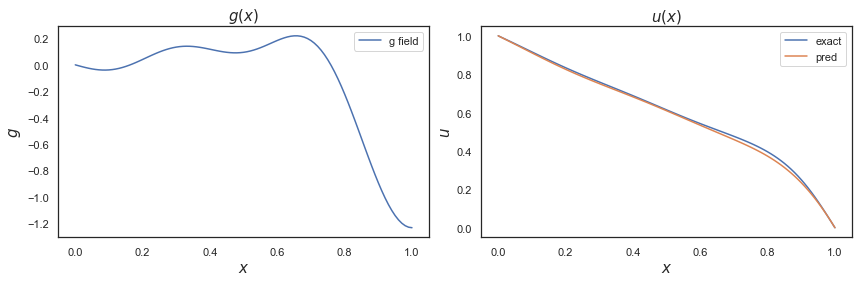

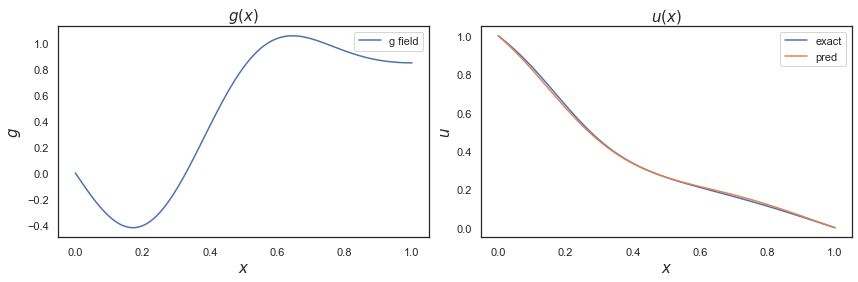

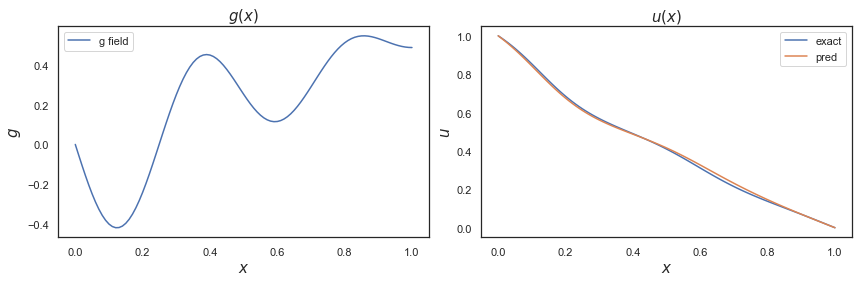

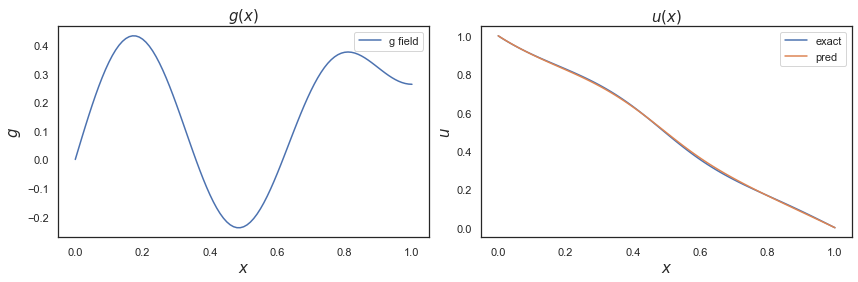

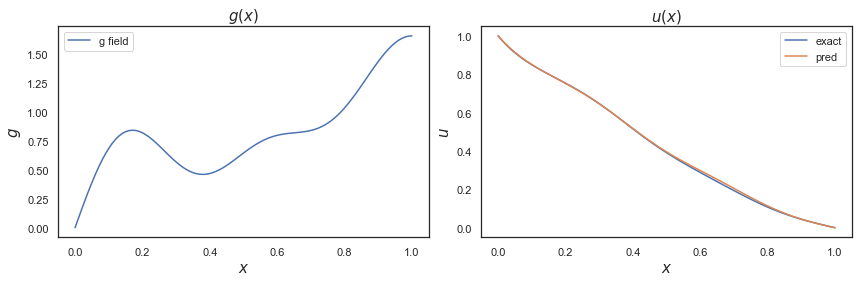

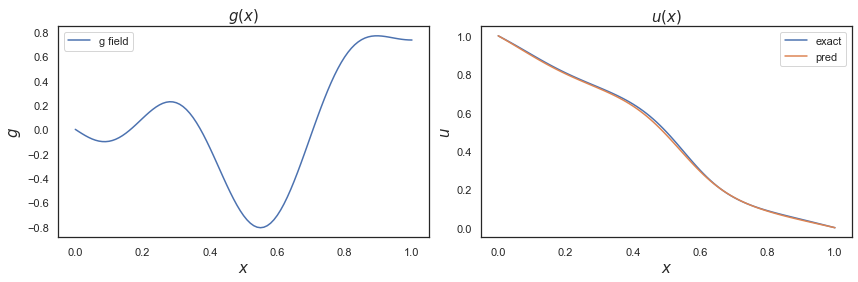

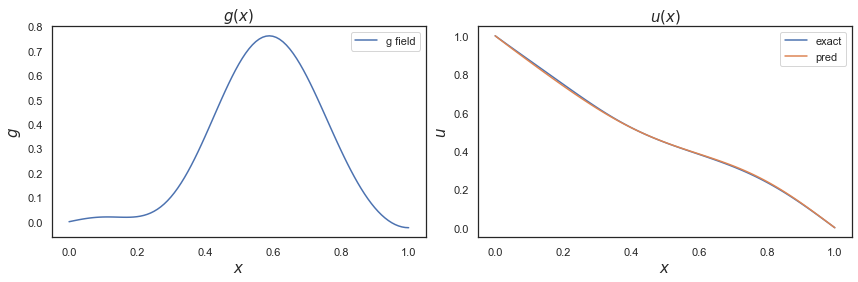

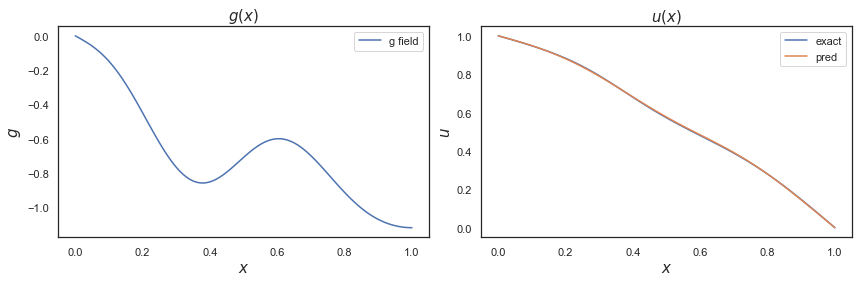

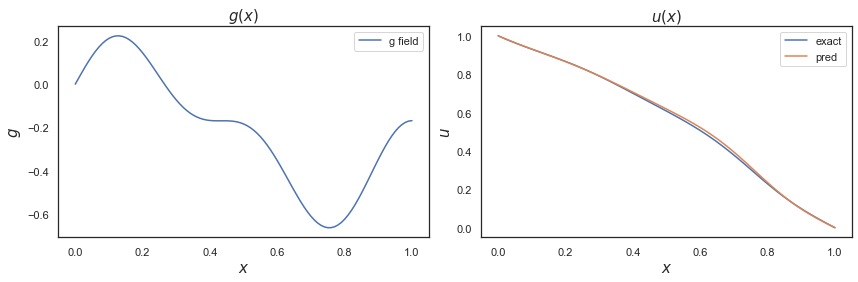

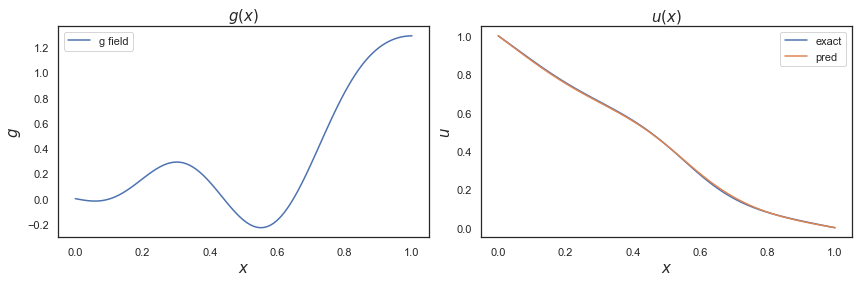

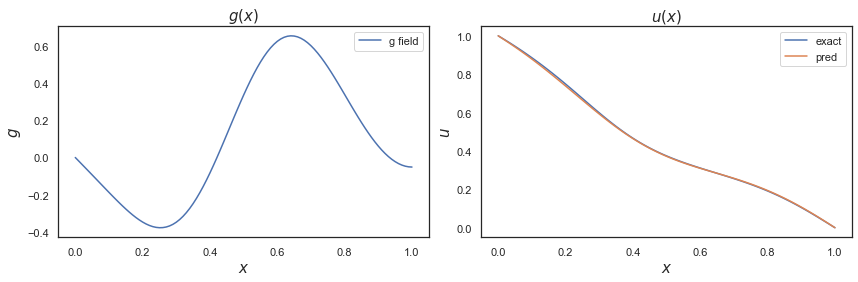

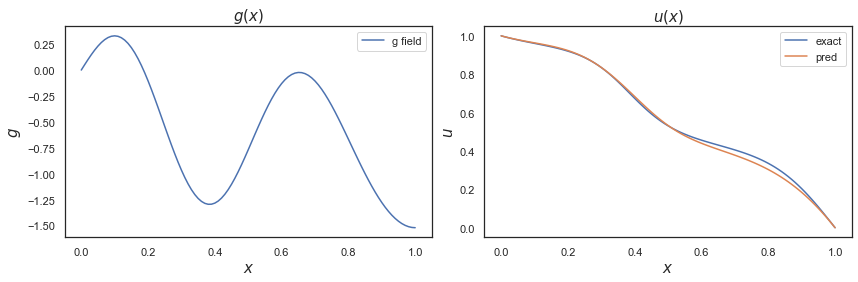

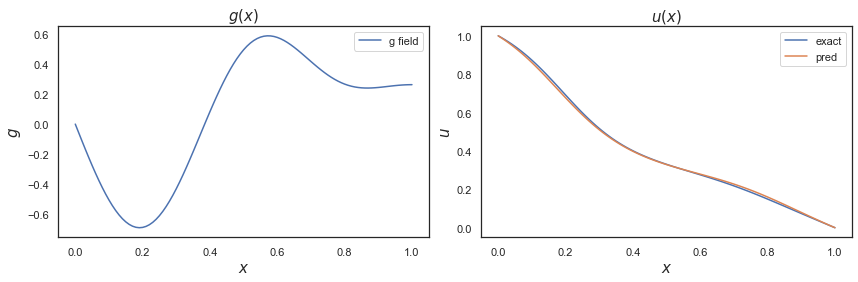

In [8]:
x_val = torch.rand((10000,1), requires_grad=True)
xi_val = xi_dist.sample([10000]) 

val_loss = loss_func(pinn, x_val, xi_val)
print('Validation loss: %.5f'%(val_loss))

solver = SteadyStateHeat1DSolver(nx=100, value_left=B1, value_right=B2)
# Plots
sns.set_style("white")
plt.rcParams.update({'font.size': 9})

for i in range(30):
    xi = xi_dist.sample() 
    x_test, u_exact = solver(xi)
    
    inputs = torch.hstack([ torch.from_numpy(x_test).reshape(-1,1).float(), xi.repeat(len(x_test),1) ])
    u_pred = u_trail( torch.from_numpy(x_test).reshape(-1,1).float(), inputs, pinn).flatten()
    
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    #print(f"xi={xi.data.numpy()}")
    ax1.plot(x_test[:,None], g(torch.from_numpy(x_test).reshape(-1,1).float(), xi.repeat(len(x_test),1), sigma=sigma), label='g field')
    ax1.set_title('$g(x)$', fontsize=15)
    ax1.set_xlabel('$x$', fontsize=15)
    ax1.set_ylabel('$g$', fontsize=15)
    ax1.legend()
    plt.tight_layout();
    
    ax2.plot(x_test, u_exact, label='exact')
    ax2.plot(x_test, u_pred.data.numpy(), label='pred')
    ax2.set_title('$u(x)$', fontsize=15)
    ax2.set_xlabel('$x$', fontsize=15)
    ax2.set_ylabel('$u$', fontsize=15)
    ax2.legend()
    plt.tight_layout();

In [9]:
sigma

1.5